# Collaboration and Competition

---

This notebook uses the [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/) environment to train two agents to play tennis.

## 1. Start the Environment

If the code cell below returns an error, please double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and all the required libraries.

In [3]:
from collections import deque

from unityagents import UnityEnvironment

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from ddpg.environment import TennisEnvironment
env = TennisEnvironment(UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis"))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents.

## 2. State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation.  Two continuous actions are available, corresponding to movement toward or away from the net, and jumping. 

The task is episodic, and in order to solve the environment, the agents must get an average score of +0.5 over 100 consecutive episodes, after taking the maximum over both agents. Specifically,

- After each episode, we add up the rewards that each agent received without discounting, to get a score for each agent. This yields two potentially different scores. We then take the maximum of these 2 scores.
- This yields a single **score** for each episode.

The environment is considered solved, when the average over 100 episodes of those **scores** is at least +0.5.

Run the code cell below to print some information about the environment.

### 2.1 Examine state and action spaces

In [5]:
print('There are {} agents. Each observation is a state with length: {}'.format(env.num_agents, env.state_size))
print('The state for the first agent looks like:', env.reset(train_mode=True)[0])

There are 2 agents. Each observation is a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -7.38993645 -1.5        -0.          0.
  6.83172083  5.99607611 -0.          0.        ]


## 3. Define the training policy

In [6]:
def maddpg(agent, n_episodes=10000, max_t=1000):
    
    scores = []                        # list with the scores from each episode
    scores_window = deque(maxlen=100)  # last 10 scores
    scores_window_mean =  []           # the mean of the last 10 episodes
    scores_window_std  =  []           # std of the last 10 episodes
    
    for episode in range(1, n_episodes+1):
        states = env.reset(train_mode=True)
        score = np.zeros(len(agent))
        for t in range(max_t):
            actions = agent.act(states)
            next_states, rewards, dones = env.step(actions)
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            
            if np.any(dones):
                break

        scores.append(np.max(score))
        scores_window.append(np.max(score))
        scores_window_mean.append(np.mean(scores_window))
        scores_window_std.append(np.std(scores_window))
        
        print('\rEpisode {}\tAverage Score: {:.3f}\tstd: {:.3f}\tScore: {:.3f}'.
              format(episode, scores_window_mean[-1], scores_window_std[-1], scores[-1]), end="")
        
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}\tstd: {:.3f}\tScore: {:.3f}'.
                  format(episode, scores_window_mean[-1], scores_window_std[-1], scores[-1])) 
        if scores_window_mean[-1] > 0.5:
            print('\nEnvironment solved in {:d} episodes!\tScore: {:.3f}'.
                  format(episode, scores_window_mean[-1]))
            
            filename = "checkpoints/{}_checkpoint_{}_{}.pth"

            for id in np.arange(len(agent)):
                torch.save(agent[id].actor_local.state_dict(),  filename.format(agent.__name__.lower(), "actor", id))
                torch.save(agent[id].critic_local.state_dict(), filename.format(agent.__name__.lower(), "critic", id))
            break
            
    return scores, scores_window_mean, scores_window_std    

MADDPG Agent

In [7]:
configurationParameters = {"buffer_size":int(1e5), "batch_size":200,  
                           "lr_actor":1e-4, "lr_critic":1e-3,
                           "gamma":0.99, "weight_decay":0, 
                           "tau":1e-3, "update_frequency":2, 
                           "n_learns":1}

print(configurationParameters)

from ddpg.multiagent import MultiAgent
agent = MultiAgent(env.num_agents, env.state_size, env.action_size, seed=0, 
                   hyperparameters=configurationParameters)

{'buffer_size': 100000, 'batch_size': 200, 'lr_actor': 0.0001, 'lr_critic': 0.001, 'gamma': 0.99, 'weight_decay': 0, 'tau': 0.001, 'update_frequency': 2, 'n_learns': 1}


Checking the architecture of actor and critic networks of the agents

In [8]:
for id in np.arange(len(agent)):
    print("agent:", id + 1)
    print(agent[id].actor_local)
    print(agent[id].critic_local)
    print("\n")

agent: 1
Actor(
  (fc1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=2, bias=True)
)
Critic(
  (fcs1): Linear(in_features=52, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


agent: 2
Actor(
  (fc1): Linear(in_features=24, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=2, bias=True)
)
Critic(
  (fcs1): Linear(in_features=52, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)




Training the agents

In [9]:
scores, scores_window_mean, scores_window_std = maddpg(agent)

Episode 100	Average Score: 0.007	std: 0.025	Score: 0.000
Episode 200	Average Score: 0.007	std: 0.026	Score: 0.000
Episode 300	Average Score: 0.000	std: 0.000	Score: 0.000
Episode 400	Average Score: 0.000	std: 0.000	Score: 0.000
Episode 500	Average Score: 0.000	std: 0.000	Score: 0.000
Episode 600	Average Score: 0.001	std: 0.010	Score: 0.000
Episode 700	Average Score: 0.015	std: 0.036	Score: 0.000
Episode 800	Average Score: 0.001	std: 0.010	Score: 0.000
Episode 900	Average Score: 0.000	std: 0.000	Score: 0.000
Episode 1000	Average Score: 0.000	std: 0.000	Score: 0.000
Episode 1100	Average Score: 0.018	std: 0.038	Score: 0.000
Episode 1200	Average Score: 0.016	std: 0.036	Score: 0.000
Episode 1300	Average Score: 0.033	std: 0.047	Score: 0.000
Episode 1400	Average Score: 0.062	std: 0.060	Score: 0.090
Episode 1500	Average Score: 0.064	std: 0.053	Score: 0.090
Episode 1600	Average Score: 0.080	std: 0.077	Score: 0.100
Episode 1700	Average Score: 0.116	std: 0.082	Score: 0.190
Episode 1800	Average Sc

## 4. Plot the scores

In [10]:
def plot_scores(scores, rolling_mean, rolling_std, title, filename=''):
    
    """Plot the scores with the moving average"""
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    
    ax.axhline(y=0.5, xmin=0.0, xmax=1.0, color='r', linestyle='--', alpha=0.9, label="Score threshold baseline")
    
    plt.plot(np.arange(len(scores)), scores);
    plt.plot(np.arange(len(rolling_mean)), rolling_mean,label='Moving average');
    plt.fill_between(np.arange(len(rolling_mean)), rolling_mean + rolling_std, rolling_mean - rolling_std, 
                     facecolor='green', alpha=0.4, label="Std of the moving average");
    plt.ylabel("Score"); plt.xlabel("Episode #"); plt.title(title);
    ax.legend(loc='upper left')
    ax.set_xlim(0, len(scores) + 1)
    
    if filename != '':
        fig.savefig(filename, format='pdf')

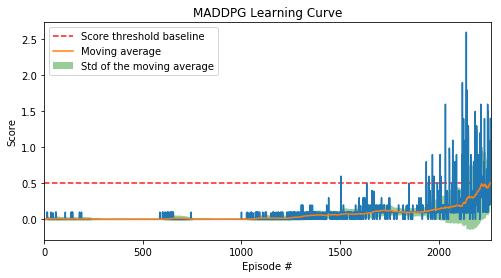

In [11]:
plot_scores(scores, np.array(scores_window_mean), np.array(scores_window_std), 
            title='MADDPG Learning Curve', filename='report/figures/{}_score.pdf'.format(agent.__name__.lower()));

## 5. Watch a smart agent

In [13]:
def smart_maddpg():
    """"""
    for id in range(len(agent)):
        actor_filename = 'checkpoints/{}_checkpoint_{}_{}.pth'.format(agent.__name__.lower(), "actor", id)
        agent[id].actor_local.load_state_dict(torch.load(actor_filename))
        
        critic_filename = 'checkpoints/{}_checkpoint_{}_{}.pth'.format(agent.__name__.lower(), "critic", id)
        agent[id].critic_local.load_state_dict(torch.load(critic_filename))
    
    states = env.reset(train_mode=False)                   # reset the environment
    scores = np.zeros(env.num_agents)                      # initialize the score for each agent
    
    while True:
        actions = agent.act(states)                        # select actions from loaded model agent
        next_states, rewards, dones = env.step(actions)    # send the actions to the environment
        scores += rewards                                  # update the score for each agent
        states = next_states                               # roll over states to next time step
        
        if np.any(dones):                                  # exit loop if episode finished
            break
    return np.mean(scores)

print('Total score: {}'.format(smart_maddpg()))

Total score: 0.8450000127777457


## Close the environment

In [ ]:
env.close()